# Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Data Preprocesssing

In [2]:
# Load the data
train_data = pd.read_csv('/kaggle/input/obesity-dataset/ObesityDataSet_raw_and_data_sinthetic.csv')

In [3]:
# Remove Unimportant Features
train_data = train_data.drop(columns=['family_history_with_overweight', 'SCC', 'FAVC', 'MTRANS', 'CAEC', 'SMOKE', 'CALC'])

In [4]:
# Display the first few rows of the DataFrame
train_data.head()

,Age,Gender,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad
0,21.0,Female,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight
1,21.0,Female,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight
2,23.0,Male,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight
3,27.0,Male,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I
4,22.0,Male,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_II


In [5]:
# Check for missing values
train_data.isnull().sum()

Age           0
Gender        0
Height        0
Weight        0
FCVC          0
NCP           0
CH2O          0
FAF           0
TUE           0
NObeyesdad    0
dtype: int64

In [6]:
# Check for duplicated values

duplicates = train_data.duplicated()

# Count the number of duplicated rows
num_duplicates = duplicates.sum()

print("Number of duplicated rows:", num_duplicates)

Number of duplicated rows: 25


In [7]:
# Remove duplicate rows
train_data = train_data.drop_duplicates()

# Reset index after dropping duplicates
train_data = train_data.reset_index(drop=True)

# Verify if duplicates are removed
print("Number of duplicated rows after removal:", train_data.duplicated().sum())

Number of duplicated rows after removal: 0


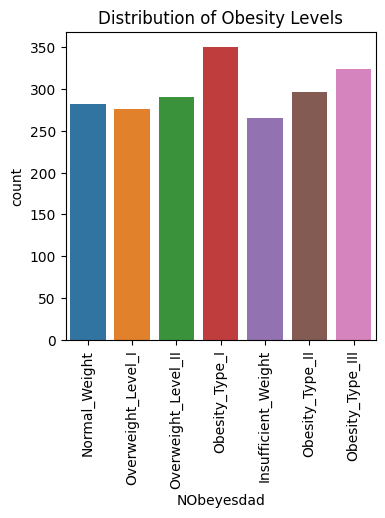

In [8]:
# Visualize the distribution of the target variable (NObeyesdad)

plt.figure(figsize=(4, 4))
sns.countplot(x='NObeyesdad', data=train_data)
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=90)
plt.show()

In [9]:
# Save the cleaned dataset to a new CSV file
train_data.to_csv("Cleaned_ObesityDataSet.csv", index=False)
print(f"Number of rows in Cleaned_ObesityDataSet.csv: {train_data.shape[0]}")


print("Dataset saved successfully as 'Cleaned_ObesityDataSet.csv'")

Number of rows in Cleaned_ObesityDataSet.csv: 2086
Dataset saved successfully as 'Cleaned_ObesityDataSet.csv'


# Feature Engineering

In [10]:
# Calculate BMI and add as a new column
train_data['BMI'] = train_data['Weight'] / (train_data['Height'] ** 2)

# Drop the Height and Weight columns
train_data = train_data.drop(columns=['Height', 'Weight'])

# Save the modified dataset to a new CSV file
train_data.to_csv("ObesityDataSet_with_BMI.csv", index=False)

print("Dataset saved successfully as 'ObesityDataSet_with_BMI.csv'")

Dataset saved successfully as 'ObesityDataSet_with_BMI.csv'


# Training Model

In [11]:
# Encode target variable into numerical labels
label_encoder = LabelEncoder()
train_data['NObeyesdad'] = label_encoder.fit_transform(train_data['NObeyesdad'])

In [12]:
# Split features and target variable

X = train_data.drop(columns=['NObeyesdad'])
y = train_data['NObeyesdad']

In [13]:
# Define categorical and numerical features

categorical_features = ['Gender']
numerical_features = ['Age', 'BMI', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [14]:
# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [16]:
from xgboost import XGBClassifier

# Define the XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)

In [17]:
# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_model)])

In [18]:
# Define hyperparameters for randomized search (XGBoost)
param_grid = {
    'classifier__n_estimators': [30, 50, 70],  
    'classifier__max_depth': [1, 2],           
    'classifier__learning_rate': [0.01, 0.05], 
    'classifier__subsample': [0.5],            
    'classifier__colsample_bytree': [0.5],     
    'classifier__min_child_weight': [10, 15],  
    'classifier__reg_alpha': [1.0, 2.0],      
    'classifier__reg_lambda': [2.0, 5.0]    
}

In [19]:
# Perform randomized search cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                   n_iter=20, 
                                   cv=5, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)

# Fit the random search to the training data.
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'BMI',
                                                                                'FCVC',
                                                                                'NCP',
                                                                                'CH2O',
                                                                                'FAF',
                                                                                'TUE']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender'])])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callb...
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [0.5],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05],
                                        'classifier__max_depth': [1, 2],
                                        'classifier__min_child_weight': [10,
                                                                         15],
                                        'classifier__n_estimators': [30, 50,
                                                                     70],
                                        'classifier__reg_alpha': [1.0, 2.0],
                                        'classifier__reg_lambda': [2.0, 5.0],
                                        'classifier__subsample': [0.5]},
                   random_state=42, verbose=2)

In [20]:
# Get the best parameters

best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [21]:
# Print the best parameters
print("Best Parameters:", best_params)
print("Best Score:", random_search.best_score_)

Best Parameters: {'classifier__subsample': 0.5, 'classifier__reg_lambda': 2.0, 'classifier__reg_alpha': 1.0, 'classifier__n_estimators': 70, 'classifier__min_child_weight': 10, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.5}
Best Score: 0.9684931506849315


In [22]:
# Evaluate the best model on the validation set
accuracy = best_model.score(X_test, y_test)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9792332268370607


In [23]:
# best model on entire dataset
best_model.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'BMI', 'FCVC', 'NCP',
                                                   'CH2O', 'FAF', 'TUE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=70, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

# Learning Curves

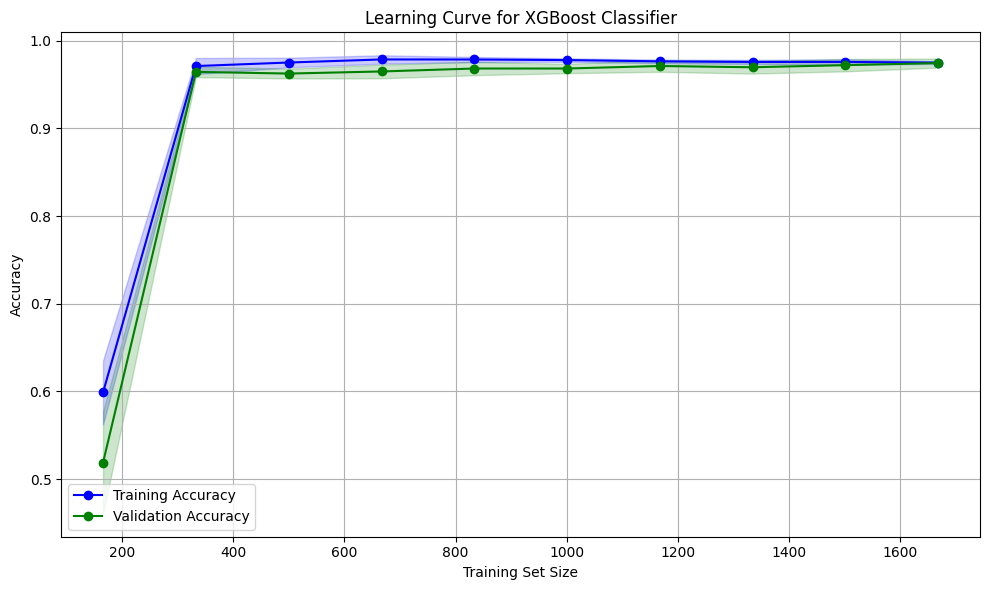

In [24]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use the best pipeline from RandomizedSearchCV
final_pipeline = random_search.best_estimator_

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    estimator=final_pipeline,
    X=X,
    y=y,
    cv=5,  # 5-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calculate means and std dev
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning Curve for XGBoost Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


# Loss Function 

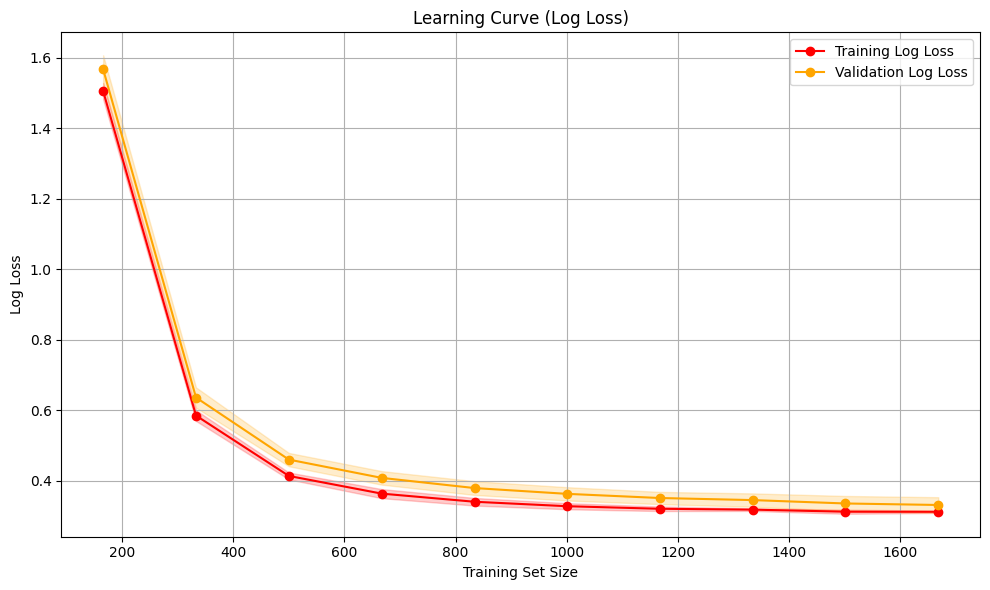

In [25]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use the best pipeline from RandomizedSearchCV
final_pipeline = random_search.best_estimator_

# Define train sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# --- Log Loss Learning Curve ---
train_sizes_loss, train_scores_loss, val_scores_loss = learning_curve(
    estimator=final_pipeline,
    X=X,
    y=y,
    cv=5,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean_loss = -np.mean(train_scores_loss, axis=1)  # negate because of 'neg_log_loss'
val_mean_loss = -np.mean(val_scores_loss, axis=1)
train_std_loss = np.std(-train_scores_loss, axis=1)
val_std_loss = np.std(-val_scores_loss, axis=1)

# --- Plot Log Loss Learning Curve ---
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_loss, train_mean_loss, 'o-', color='red', label='Training Log Loss')
plt.fill_between(train_sizes_loss, train_mean_loss - train_std_loss, train_mean_loss + train_std_loss, alpha=0.2, color='red')
plt.plot(train_sizes_loss, val_mean_loss, 'o-', color='orange', label='Validation Log Loss')
plt.fill_between(train_sizes_loss, val_mean_loss - val_std_loss, val_mean_loss + val_std_loss, alpha=0.2, color='orange')
plt.title('Learning Curve (Log Loss)')
plt.xlabel('Training Set Size')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation

Validation Accuracy: 0.9824281150159745

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        89
      Normal_Weight       0.98      1.00      0.99        95
     Obesity_Type_I       0.97      0.99      0.98       112
    Obesity_Type_II       0.99      0.97      0.98       101
   Obesity_Type_III       1.00      1.00      1.00        85
 Overweight_Level_I       0.97      0.96      0.96        71
Overweight_Level_II       0.96      0.97      0.97        73

           accuracy                           0.98       626
          macro avg       0.98      0.98      0.98       626
       weighted avg       0.98      0.98      0.98       626


Confusion Matrix:
[[ 87   2   0   0   0   0   0]
 [  0  95   0   0   0   0   0]
 [  0   0 111   1   0   0   0]
 [  0   0   3  98   0   0   0]
 [  0   0   0   0  85   0   0]
 [  0   0   0   0   0  68   3]
 [  0   0   0   0   0   2  71]]


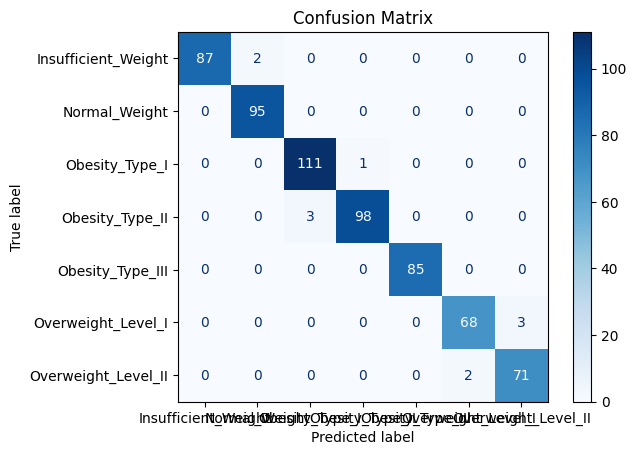

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Save the best trained model

In [27]:
import joblib

# Save model
joblib.dump(best_model, '/kaggle/working/Obesity_Risk_Model.pkl')

joblib.dump(label_encoder,'/kaggle/working/label_encoder.pkl')

['/kaggle/working/label_encoder.pkl']

# Performance Evaluation

In [28]:
# Step 1: Prepare the new test data
new_test_data = pd.read_csv('/kaggle/input/obesity-real-world-data/obesity_test_data.csv')

# Step 2: Calculate BMI = Weight / (Height^2)
new_test_data['BMI'] = new_test_data['Weight'] / (new_test_data['Height'] ** 2)

# Drop Height and Weight as your model uses BMI instead
new_test_data.drop(columns=['Height', 'Weight','id','family_history_with_overweight', 'FAVC','CAEC','SMOKE','SCC','CALC','MTRANS'], inplace=True)

# Step 3: Encode the target label for evaluation
new_test_data['NObeyesdad_encoded'] = label_encoder.transform(new_test_data['NObeyesdad'])

# Split features and labels
X_new = new_test_data.drop(columns=['NObeyesdad', 'NObeyesdad_encoded'])
y_new = new_test_data['NObeyesdad_encoded']

# Step 4: Predict
y_new_pred = best_model.predict(X_new)

# Convert predictions back to original labels
y_new_labels = label_encoder.inverse_transform(y_new)
y_new_pred_labels = label_encoder.inverse_transform(y_new_pred)



In [29]:
new_test_data.head()

,Gender,Age,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,BMI,NObeyesdad_encoded
0,Female,26.000000,3.0,3.0,2.447306,0.000000,0.486558,Obesity_Type_III,43.395986,4
1,Female,22.000000,3.0,3.0,2.000000,2.000000,1.000000,Normal_Weight,20.195092,1
2,Female,19.000000,2.0,4.0,2.000000,2.000000,1.000000,Insufficient_Weight,19.382145,0
3,Female,19.407204,3.0,1.0,2.654702,0.000000,0.000000,Insufficient_Weight,15.601527,0
4,Female,19.407204,3.0,1.0,1.000000,0.750111,1.000000,Insufficient_Weight,17.871057,0


Confusion Matrix:
[[105   5   0   0   0   0   0]
 [  3 142   0   0   0   5   0]
 [  0   0 119   8   1   3   7]
 [  0   0   6 164   0   0   0]
 [  0   0   1   0 204   1   0]
 [  1   8   1   0   0  85  15]
 [  0   5   8   2   0  15  86]]


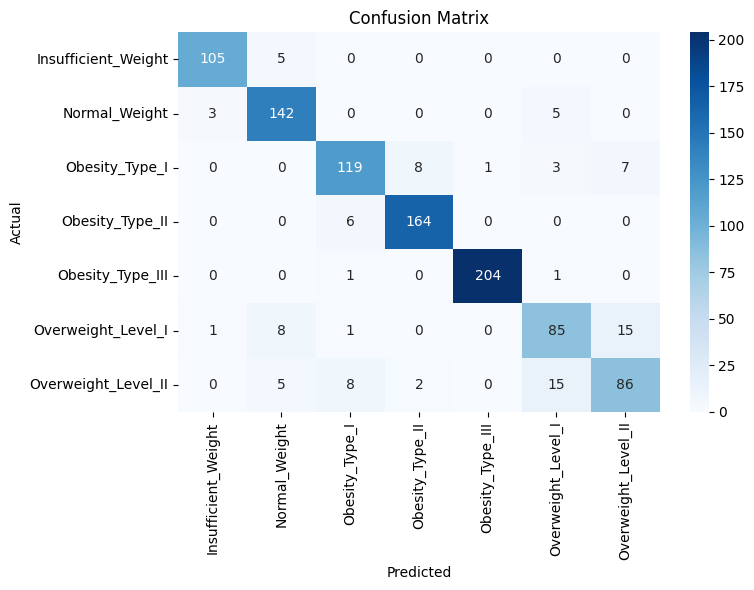

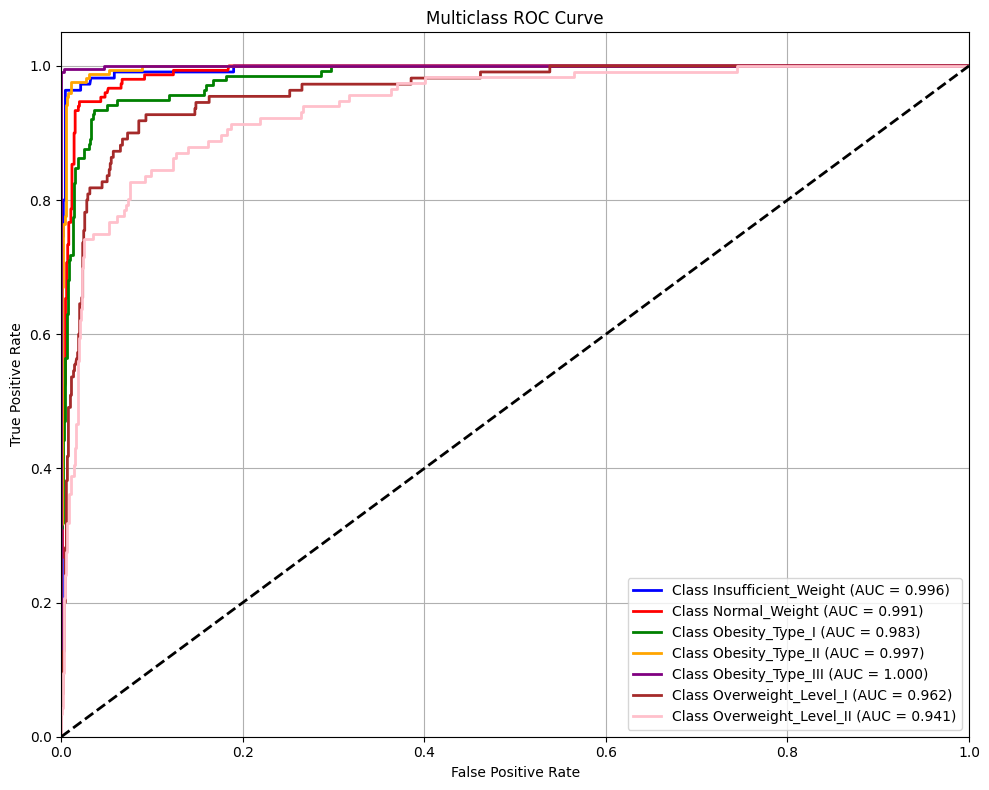

In [30]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Step 1: Confusion Matrix
conf_matrix = confusion_matrix(y_new, y_new_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix visually
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 2: ROC Curve for multiclass
# Binarize the output labels
n_classes = len(label_encoder.classes_)
y_new_binarized = label_binarize(y_new, classes=list(range(n_classes)))
y_new_pred_proba = best_model.predict_proba(X_new)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_new_binarized[:, i], y_new_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.95      0.96       110
      Normal_Weight       0.89      0.95      0.92       150
     Obesity_Type_I       0.88      0.86      0.87       138
    Obesity_Type_II       0.94      0.96      0.95       170
   Obesity_Type_III       1.00      0.99      0.99       206
 Overweight_Level_I       0.78      0.77      0.78       110
Overweight_Level_II       0.80      0.74      0.77       116

           accuracy                           0.91      1000
          macro avg       0.89      0.89      0.89      1000
       weighted avg       0.90      0.91      0.90      1000



<Figure size 1000x600 with 0 Axes>

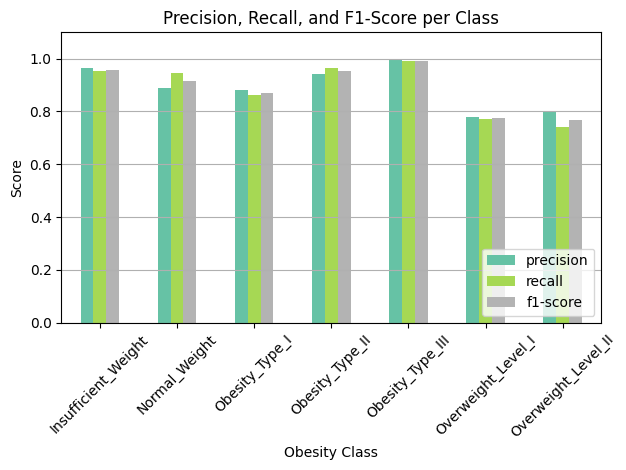

In [31]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Step 5: Get classification report as dict and text
report_dict = classification_report(y_new, y_new_pred, target_names=label_encoder.classes_, output_dict=True)
report_text = classification_report(y_new, y_new_pred, target_names=label_encoder.classes_)

# 👉 Display the classification report as text
print("Classification Report:\n")
print(report_text)

# Step 6: Convert dict to DataFrame and extract key metrics
report_df = pd.DataFrame(report_dict).transpose()
metrics_df = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Step 7: Plotting the metrics
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', colormap='Set2')
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xlabel('Obesity Class')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


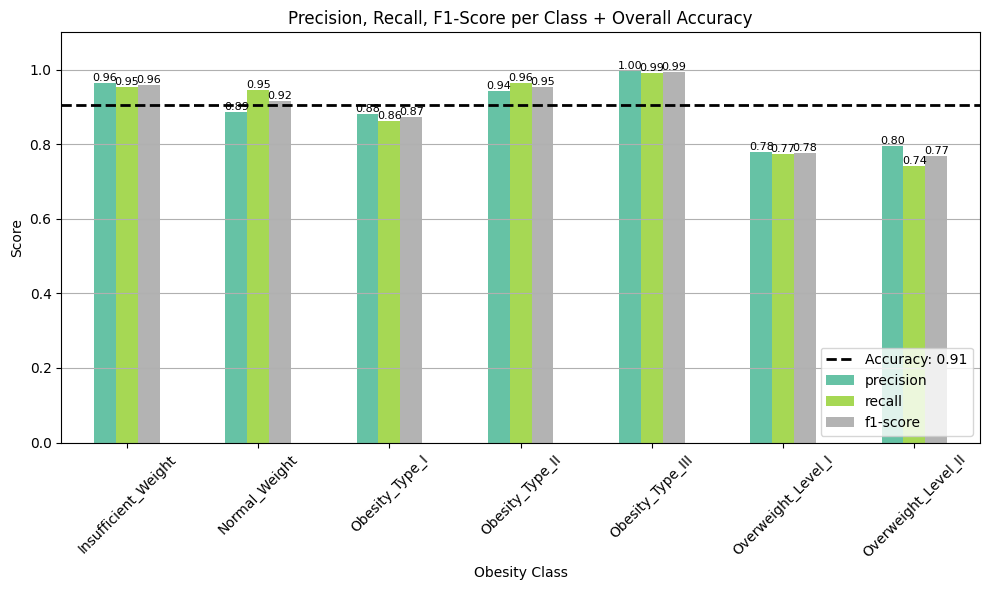

In [32]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Calculate accuracy
accuracy = accuracy_score(y_new, y_new_pred)

# Get classification report
report = classification_report(y_new, y_new_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Extract per-class metrics only
metrics_df = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot per-class metrics
ax = metrics_df.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title('Precision, Recall, F1-Score per Class + Overall Accuracy')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xlabel('Obesity Class')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8, rotation=0)

# Add accuracy as a horizontal line
plt.axhline(y=accuracy, color='black', linestyle='--', linewidth=2, label=f'Accuracy: {accuracy:.2f}')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()